In [ ]:
import pandas as pd
import numpy as np
import re
from textblob import TextBlob
import nltk
import csv
from collections import Counter
from sklearn import datasets, linear_model, model_selection, svm, tree
import matplotlib.pylab as plt
from tqdm import tqdm
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Functions for importing data

In [ ]:
def read_data(path, delimiter='|'):
    data = []
    with open(path, 'r') as file:
        reader = csv.reader(file, delimiter=delimiter)
        for row in reader:
            data.append(row)
    return data

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [ ]:
def extract(text):
    if len(text) > 30:
        features = {}

        features["insane_punctuation_count"] = len(re.findall('[^\w\s\'\"]{3,}', text))

        tokens = nltk.word_tokenize(text)
        tokens_count = len(tokens)

        features["tokens_count"] = tokens_count

        tagged = nltk.pos_tag(tokens, tagset='universal')
        tagged = [t for t in tagged if (len(t[0]) != 1) or (t[1] == '.') or (t[0] == 'a')]

        words_all = [t[0] for t in tagged if t[1] != '.']
        two_gram = [(words_all[i], words_all[i+1]) for i in range(len(words_all)-1)]
        two_gram_dict = {}
        for g in two_gram:
            if g in two_gram_dict:
                two_gram_dict[g] += 1
            else:
                two_gram_dict[g] = 1
        features["2-gram"] = two_gram_dict

        len_sum = sum(len(w) for w in words_all)

        features["average_word_length"] = len_sum / len(words_all)

        tag_fd = nltk.FreqDist(tag for (word, tag) in tagged)

        features["tag_fd"] = tag_fd

        words = [w[0] for w in tagged if (w[1] in ['ADJ', 'ADV', 'NOUN', 'VERB', 'X']) and (len(w[0]) > 1) ]
        words_count = len(words)

        features["words_count"] = words_count

        features["unique_words_count"] = len(Counter(words).keys())

        uppercase_number = sum(1 for _ in filter(lambda str: str.isupper(), words))

        features["uppercase_fraction"] = uppercase_number/ words_count

        tb = TextBlob(text)
        features["polarity"] = tb.polarity
        features["subjectivity"] = tb.subjectivity

        return features

    else:
        return 0

In [ ]:
def extract_to_dataframe(data, label):
    data_features = []

    for idx in tqdm(range(len(data))):
        article_features = extract(data[idx][1])
        selected_features = {
            'label': label,
            'tokens_count': article_features["tokens_count"],
            'words_count': article_features["words_count"], 
            'unique_words_count': article_features["unique_words_count"], 
            'polarity_score': article_features["polarity"], 
            'subjectivity_score': article_features["subjectivity"],
            'uppercase_fraction': article_features["uppercase_fraction"],
            'average_word_length': article_features["average_word_length"],
            'insane_punctuation_count': article_features['insane_punctuation_count'],
            'adj_freq': article_features["tag_fd"].freq("ADJ"), 
            'adv_freq': article_features["tag_fd"].freq("ADV"),
            'noun_freq': article_features["tag_fd"].freq("NOUN"),
            'verb_freq': article_features["tag_fd"].freq("VERB"),
            'other_freq': article_features["tag_fd"].freq("X"),
            'vocabulary_richness': article_features["unique_words_count"]/article_features["words_count"]
        }

        data_features.append(selected_features)

    df = pd.DataFrame.from_dict(data_features)

    return df

# Importing our data

In [ ]:
real_data_test = read_data('reliable-test.csv')
real_data_train = read_data('reliable-train.csv')
fake_data_test = read_data('zlo_test.csv')
fake_data_train = read_data('zlo_train.csv')

In [ ]:
df_real_test = extract_to_dataframe(real_data_test, 1)
df_real_train = extract_to_dataframe(real_data_train, 1)
df_fake_test = extract_to_dataframe(fake_data_test, -1)
df_fake_train = extract_to_dataframe(fake_data_train, -1)

100%|██████████| 80/80 [00:03<00:00, 23.73it/s]


In [ ]:
test_df = pd.concat([df_real_test,df_fake_test])
train_df= pd.concat([df_real_train, df_fake_train])

In [ ]:
df = pd.concat([test_df, train_df], ignore_index = True)

# Function for data analysis

In [ ]:
def analyze(df_fake, df_real):
    attrs = ['tokens_count', 'words_count', 'unique_words_count', 'polarity', 'subjectivity', 'uppercase_fraction', 'average_word_length', 'insane_punctuation_count', 'adj_freq', 'adv_freq', 'noun_freq', 'verb_freq', 'other_freq', 'vocabulary_richness']
    for attr in attrs:
        plt.hist(df_fake[attr], bins=100, label='Fake')
        plt.hist(df_real[attr], bins=100, label='True')
        plt.legend()
        plt.title(str(attr))
        plt.figure()
        print("Mean "+str(attr)+" in fake articles:")
        print(df_fake[attr].mean())
        print("Mean "+str(attr)+" in real articles:")
        print(df_real[attr].mean())

# AdaBoost on our data:hand-picked training set

Test datasets size: 46.00
True positives: 18.00 
False positives: 6.00 
True negatives: 14.00 
False negatives: 8.00 
Error: 0.304 
Smallest error: 0.152 
Train error: 0.037 


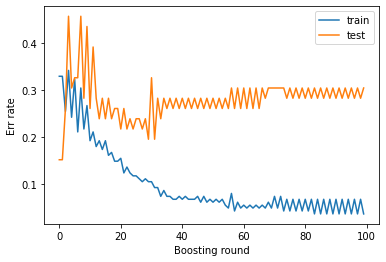

In [ ]:
X = np.array(train_df[train_df.columns[1:]])
Y = np.array(train_df['label'])

testX = np.array(test_df[test_df.columns[1:]])
testY = np.array(test_df['label'])

T = 100
W = np.ones(Y.shape)

H = []

Y_scores = 0
train_errs = []
train_loss = []

testY_scores = 0
test_errs = []

completeY_scores = []


for t in range(T):
    f_t = tree.DecisionTreeClassifier(max_depth=1).fit(X, Y, W)
    err_t = ((f_t.predict(X) != Y) * W).mean()
    if err_t > 0.5:
        print("No weak classifier found")
        break
    alpha_t = 0.5 * np.log((1 - err_t) / err_t)
    H.append((alpha_t, f_t))
    W *= np.exp(-alpha_t * Y * f_t.predict(X))

    Y_scores += alpha_t * f_t.predict(X)
    train_errs.append((np.sign(Y_scores) != Y).mean())
    train_loss.append(np.exp(-Y_scores * Y).mean())

    testY_scores += alpha_t * f_t.predict(testX)
    test_errs.append((np.sign(testY_scores) != testY).mean())
    completeY_scores.append(testY_scores)


plt.figure()
plt.plot(train_errs, label="train")
plt.plot(test_errs, label="test")
plt.xlabel("Boosting round")
plt.ylabel("Err rate")
_ = plt.legend()
test_errs = np.array(test_errs)
I = test_errs.argsort()
total_smallest_errors = (test_errs[I[0]])
total_errors = test_errs[-1]
TP = ((np.sign(completeY_scores[I[0]]) == 1) & (testY == 1)).sum()
FP = ((np.sign(completeY_scores[I[0]]) == 1) & (testY == -1)).sum()
TN = ((np.sign(completeY_scores[I[0]]) == -1) & (testY == -1)).sum()
FN = ((np.sign(completeY_scores[I[0]]) == -1) & (testY == 1)).sum()

print("Test datasets size: %.2f" % (TP + FP + FN + TN))
print("True positives: %.2f " % TP)
print("False positives: %.2f " % FP)
print("True negatives: %.2f " % TN)
print("False negatives: %.2f " % FN)
print("Error: %.3f " % total_errors)
print("Smallest error: %.3f " % total_smallest_errors)
print("Train error: %.3f " % train_errs[-1])

# XGBoost on our data: hand-picked training set

Error rate: 0.130 
Training set error rate: 0.155
True positives: 23.00 
False positives: 3.00 
True negatives: 17.00 
False negatives: 3.00 


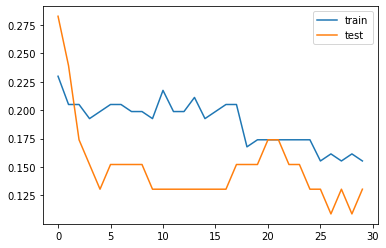

In [ ]:
attrs = ['tokens_count', 'words_count', 'unique_words_count', 'polarity', 'subjectivity', 'uppercase_fraction', 'average_word_length', 'insane_punctuation_count', 'adj_freq', 'adv_freq', 'noun_freq', 'verb_freq', 'other_freq', 'vocabulary_richness']

TP = []
FP = []
TN = []
FN = []


colsample_bytree = 0.3
learning_rate = 0.01
max_depth = 3
alpha = 10
n_estimators = 30


X = np.array(train_df[train_df.columns[1:]])
Y = np.array(train_df['label'] + 1)/2

testX = np.array(test_df[test_df.columns[1:]])
testY = np.array(test_df['label'] + 1)/2

eval_s = [(X, Y),(testX,testY)]
xg_reg = xgb.XGBRegressor(objective ='reg:logistic', colsample_bytree = colsample_bytree, learning_rate = learning_rate,
                max_depth = max_depth, eval_metric='error', alpha = alpha, n_estimators = n_estimators)

test_params = {
    'learing_rate':[0.01, 0.05, 0.1]
}
xg_reg.fit(X,Y, eval_set=eval_s, verbose=False)
model = GridSearchCV(estimator = xg_reg,param_grid = test_params, verbose = False)
model.fit(X,Y, eval_set=eval_s, verbose=False)
preds = model.predict(testX)
r = model.best_estimator_.evals_result()

plt.plot(r['validation_0']['error'], label = "train")
plt.plot(r['validation_1']['error'], label = "test")
plt.legend()

preds = np.round(preds)
TP = ((preds == 1) & (testY == 1)).sum()
FP = ((preds == 1) & (testY == 0)).sum()
TN = ((preds == 0) & (testY == 0)).sum()
FN = ((preds == 0) & (testY == 1)).sum()

preds = model.predict(X)
preds = np.round(preds)
train_error_rate = (preds != Y).sum()/len(Y)

error_rate = (FP + FN)/(TP + FP + TN + FN)
print("Error rate: %.3f " % error_rate)
print("Training set error rate: %.3f" % train_error_rate)
print("True positives: %.2f " % TP)
print("False positives: %.2f " % FP)
print("True negatives: %.2f " % TN)
print("False negatives: %.2f " % FN)


# Feature importance from XGBoost

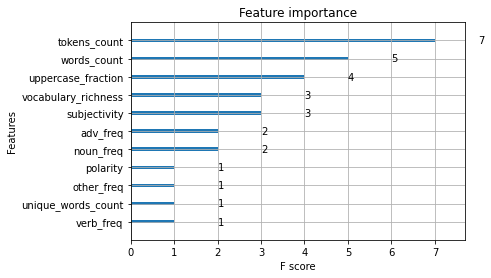

In [ ]:
params = {"objective":"reg:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
data_dmatrix = xgb.DMatrix(data=X,label=Y, feature_names=attrs)
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
xgb.plot_importance(xg_reg)
plt.show()

# AdaBoost on our data: leave-one-out

In [ ]:
def boost(X, testX, Y, testY):

    T = 100
    W = np.ones(Y.shape)

    H = []

    Y_scores = 0
    train_errs = []
    train_loss = []

    testY_scores = 0
    test_errs = []

    completeY_scores = []


    for t in range(T):
        f_t = tree.DecisionTreeClassifier(max_depth=1).fit(X, Y, W)
        err_t = ((f_t.predict(X) != Y) * W).mean()
        if err_t > 0.5:
            print("No weak classifier found")
            break
        alpha_t = 0.5 * np.log((1 - err_t) / err_t)
        H.append((alpha_t, f_t))
        W *= np.exp(-alpha_t * Y * f_t.predict(X))

        Y_scores += alpha_t * f_t.predict(X)
        train_errs.append((np.sign(Y_scores) != Y).mean())
        train_loss.append(np.exp(-Y_scores * Y).mean())

        testY_scores += alpha_t * f_t.predict(testX)
        test_errs.append((np.sign(testY_scores) != testY).mean())
        completeY_scores.append(testY_scores)

    test_errs = np.array(test_errs)
    I = test_errs.argsort()
    total_smallest_errors = (test_errs[I[0]])
    total_errors = test_errs[-1]
    FP = ((np.sign(completeY_scores[I[0]]) == 1) & (testY == -1)).sum()
    FN = ((np.sign(completeY_scores[I[0]]) == -1) & (testY == 1)).sum()
    return total_errors, FP, FN

In [ ]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
T, FP, FN = 0, 0, 0
errs = []

X = df[df.columns[1:]]
Y = df['label']

for train_index, test_index loo.split(X):

    train_X, test_X = X.iloc[train_index], X.iloc[test_index]
    train_Y, test_Y = Y.iloc[train_index], Y.iloc[test_index]

    te, fp, fn = boost(train_X, test_X, train_Y, test_Y)
    FP+=fp
    FN+=fn
    errs.append(te)

print("False positives: "+ str(FP))
print("False negatives: "+ str(FN))
print("Error_rate: "+str(np.array(errs).sum()/len(X)))

207it [02:00,  1.71it/s]

False positives: 32
False negatives: 31
Error_rate: 0.30434782608695654


# XGBoost on our data: leave-one-out

In [ ]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
T, FP, FN = 0, 0, 0


colsample_bytree = 0.3
learning_rate = 0.01
max_depth = 3
alpha = 10
n_estimators = 30


X = df.iloc[:,1:]
Y = (df.iloc[:,0] + 1)/2

for train_index, test_index in loo.split(X):

    train_X, test_X = X.iloc[train_index], X.iloc[test_index]
    train_Y, test_Y = Y.iloc[train_index], Y.iloc[test_index]
    xg_reg = xgb.XGBRegressor(objective ='reg:logistic', colsample_bytree = colsample_bytree, learning_rate = learning_rate,
                max_depth = max_depth, eval_metric='error', alpha = alpha, n_estimators = n_estimators)

    xg_reg.fit(train_X, train_Y)
    res = xg_reg.predict(test_X)
    res = np.round(res)

    if np.all(res == test_Y):
        T += 1
    elif np.all(res == 1) and np.all(test_Y == 0):
        FP += 1
    elif np.all(res == 0) and np.all(test_Y == 1):
        FN += 1

e = (FP + FN)/len(Y)
print(FN)
print(FP)
print(e)

32
33
0.3140096618357488


# Importing Kaggle data

In [ ]:
real_kaggle = []
with open('True.csv', 'r') as file:
    reader = csv.reader(file, delimiter=',')
    next(reader)
    i = 0
    for row in reader:
        i+=1
        real_kaggle.append([row[0], row[1]])
        if i > 10000:
            break

real_kaggle = np.array(real_kaggle)

In [ ]:
fake_kaggle = []
with open('Fake.csv', 'r') as file:
    reader = csv.reader(file, delimiter=',')
    next(reader)
    i = 0
    for row in reader:
        i+=1
        fake_kaggle.append([row[0], row[1]])
        if i > 10000:
            break

fake_kaggle = np.array(fake_kaggle)

In [ ]:
real_data = []
for r in tqdm(real_kaggle):
    features = extract(r[1])
    if features:
        real_data.append([features["tokens_count"], features["words_count"], features["unique_words_count"], features["polarity"],
                    features["subjectivity"], features["uppercase_fraction"], features["average_word_length"],
                    features["insane_punctuation_count"], features["tag_fd"].freq("ADJ"), features["tag_fd"].freq("ADV"),
                    features["tag_fd"].freq("NOUN"), features["tag_fd"].freq("VERB"), features["tag_fd"].freq("X"), features["unique_words_count"]/features["words_count"]])

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.

 34%|███▎      | 3372/10001 [01:37<03:29, 31.58it/s]


 34%|███▍      | 3376/10001 [01:37<03:42, 29.83it/s]


 34%|███▍      | 3382/10001 [01:37<03:24, 32.39it/s]


 34%|███▍      | 3386/10001 [01:38<03:36, 30.52it/s]


 34%|███▍      | 3390/10001 [01:38<03:34, 30.87it/s]


 34%|███▍      | 3394/10001 [01:38<03:36, 30.51it/s]


 34%|███▍      | 3398/10001 [01:38<03:39, 30.09it/s]


 34%|███▍      | 3402/10001 [01:38<04:14, 25.98it/s]


 34%|███▍      | 3407/10001 [01:38<03:45, 29.20it/s]


 34%|███▍      | 3411/10001 [01:38<04:04, 26.93it/s]


 34%|███▍      | 3414/10001 [01:39<04:11, 26.15it/s]


 34%|███▍      | 3419/10001 [01:39<03:54, 28.07it/s]


 34%|███▍      | 3422/10001 [01:39<04:17, 25.58it/s]


 34%|███▍      | 3426/10001 [01:39<03:54, 28.08it/s]


 34%|███▍      | 3430/10001 [01:39<03:47, 28.87it/s]


 34%|███▍      | 3434/10001 [01:39<03:59, 27.37it/s]


 34%|███▍      | 3440/10001 [01:39<03:23, 32.23it/s]



In [ ]:
real_data = np.array(real_data)

In [ ]:
df_real = pd.DataFrame({'label': 1, 'tokens_count': real_data[:, 0], 'words_count':real_data[:, 1], 'unique_words_count' : real_data[:, 2], 'polarity': real_data[:, 3],
                        'subjectivity': real_data[:, 4], 'uppercase_fraction': real_data[:, 5], 'average_word_length': real_data[:, 6], 'insane_punctuation_count': real_data[:, 7],
                        'adj_freq': real_data[:, 8], 'adv_freq': real_data[:, 9], 'noun_freq': real_data[:, 10], 'verb_freq': real_data[:, 11], 'other_freq': real_data[:, 12],
                        'vocabulary_richness': real_data[:, 13]})

In [ ]:
fake_data = []
for f in tqdm(fake_kaggle):
    features = extract(f[1])
    if features:
        fake_data.append([features["tokens_count"], features["words_count"], features["unique_words_count"], features["polarity"],
                    features["subjectivity"], features["uppercase_fraction"], features["average_word_length"],
                    features["insane_punctuation_count"], features["tag_fd"].freq("ADJ"), features["tag_fd"].freq("ADV"),
                    features["tag_fd"].freq("NOUN"), features["tag_fd"].freq("VERB"), features["tag_fd"].freq("X"), features["unique_words_count"]/features["words_count"]])

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.

 44%|████▍     | 4440/10001 [02:26<03:18, 28.05it/s]


 44%|████▍     | 4444/10001 [02:26<03:08, 29.46it/s]


 44%|████▍     | 4449/10001 [02:26<02:54, 31.87it/s]


 45%|████▍     | 4453/10001 [02:26<02:54, 31.83it/s]


 45%|████▍     | 4457/10001 [02:27<02:58, 31.13it/s]


 45%|████▍     | 4461/10001 [02:27<02:56, 31.32it/s]


 45%|████▍     | 4465/10001 [02:27<02:53, 31.90it/s]


 45%|████▍     | 4469/10001 [02:27<03:06, 29.62it/s]


 45%|████▍     | 4473/10001 [02:27<02:58, 31.02it/s]


 45%|████▍     | 4477/10001 [02:27<04:18, 21.39it/s]


 45%|████▍     | 4482/10001 [02:28<03:38, 25.24it/s]


 45%|████▍     | 4486/10001 [02:28<03:22, 27.25it/s]


 45%|████▍     | 4490/10001 [02:28<03:22, 27.28it/s]


 45%|████▍     | 4494/10001 [02:28<03:24, 26.91it/s]


 45%|████▍     | 4497/10001 [02:28<03:19, 27.53it/s]


 45%|████▍     | 4500/10001 [02:28<03:28, 26.38it/s]


 45%|████▌     | 4503/10001 [02:28<03:29, 26.28it/s]



In [ ]:
fake_data = np.array(fake_data)

In [ ]:
df_fake = pd.DataFrame({'label': -1, 'tokens_count': fake_data[:, 0], 'words_count': fake_data[:, 1], 'unique_words_count' : fake_data[:, 2], 'polarity': fake_data[:, 3],
                        'subjectivity': fake_data[:, 4], 'uppercase_fraction': fake_data[:, 5], 'average_word_length': fake_data[:, 6], 'insane_punctuation_count': fake_data[:, 7],
                        'adj_freq': fake_data[:, 8], 'adv_freq': fake_data[:, 9], 'noun_freq': fake_data[:, 10], 'verb_freq': fake_data[:, 11], 'other_freq': fake_data[:, 12],
                        'vocabulary_richness': fake_data[:, 13]})

In [ ]:
df_kaggle = pd.concat([df_real,df_fake])
df_kaggle = df_kaggle.sample(frac=1).reset_index(drop=True)

In [ ]:
df_kaggle

,label,tokens_count,words_count,unique_words_count,polarity,subjectivity,uppercase_fraction,average_word_length,insane_punctuation_count,adj_freq,adv_freq,noun_freq,verb_freq,other_freq,vocabulary_richness
0,-1,579.0,345.0,230.0,0.045861,0.464380,0.017391,4.954198,1.0,0.054482,0.070299,0.288225,0.193322,0.000000,0.666667
1,-1,427.0,234.0,157.0,0.276567,0.510745,0.000000,4.918033,0.0,0.045455,0.052632,0.303828,0.157895,0.000000,0.670940
2,1,854.0,494.0,294.0,0.110193,0.466429,0.006073,5.186170,0.0,0.075610,0.034146,0.315854,0.176829,0.000000,0.595142
3,-1,696.0,389.0,254.0,0.056427,0.489835,0.017995,4.760399,0.0,0.066568,0.042899,0.292899,0.170118,0.002959,0.652956
4,-1,369.0,200.0,151.0,0.081091,0.444151,0.000000,4.848297,0.0,0.065341,0.053977,0.241477,0.207386,0.000000,0.755000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19996,-1,433.0,229.0,168.0,-0.012900,0.685451,0.000000,4.616848,0.0,0.064439,0.040573,0.269690,0.167064,0.004773,0.733624
19997,1,948.0,486.0,325.0,0.119886,0.477809,0.004115,5.124679,0.0,0.074074,0.056713,0.281250,0.150463,0.000000,0.668724
19998,1,468.0,271.0,198.0,0.001459,0.329040,0.022140,5.273171,0.0,0.053333,0.042222,0.362222,0.144444,0.000000,0.730627
19999,1,487.0,286.0,198.0,0.127969,0.262886,0.104895,5.263923,0.0,0.048523,0.023207,0.409283,0.122363,0.000000,0.692308


# AdaBoost on Kaggle dataset

In [ ]:
train_df, test_df = model_selection.train_test_split(
    df_kaggle, test_size=0.2
)
X = np.array(train_df[df_kaggle.columns[1:]])
Y = np.array(train_df['label'])

testX = np.array(test_df[df_kaggle.columns[1:]])
testY = np.array(test_df['label'])

Test datasets size: 4001.00
True positives: 1735.00 
False positives: 298.00 
True negatives: 1698.00 
False negatives: 270.00 
Error: 0.142 
Smallest error: 0.141 
Train error: 0.136 


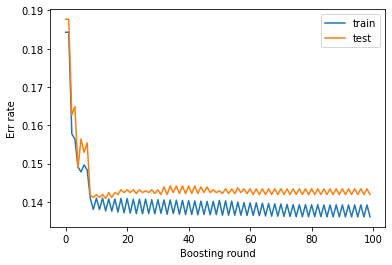

In [ ]:
T = 100
W = np.ones(Y.shape)

H = []

Y_scores = 0
train_errs = []
train_loss = []

testY_scores = 0
test_errs = []

completeY_scores = []


for t in range(T):
    f_t = tree.DecisionTreeClassifier(max_depth=1).fit(X, Y, W)
    err_t = ((f_t.predict(X) != Y) * W).mean()
    if err_t > 0.5:
        print("No weak classifier found")
        break
    alpha_t = 0.5 * np.log((1 - err_t) / err_t)
    H.append((alpha_t, f_t))
    W *= np.exp(-alpha_t * Y * f_t.predict(X))

    Y_scores += alpha_t * f_t.predict(X)
    train_errs.append((np.sign(Y_scores) != Y).mean())
    train_loss.append(np.exp(-Y_scores * Y).mean())

    testY_scores += alpha_t * f_t.predict(testX)
    test_errs.append((np.sign(testY_scores) != testY).mean())
    completeY_scores.append(testY_scores)


plt.figure()
plt.plot(train_errs, label="train")
plt.plot(test_errs, label="test")
plt.xlabel("Boosting round")
plt.ylabel("Err rate")
_ = plt.legend()
test_errs = np.array(test_errs)
I = test_errs.argsort()
total_smallest_errors = (test_errs[I[0]])
total_errors = test_errs[-1]
TP = ((np.sign(completeY_scores[I[0]]) == 1) & (testY == 1)).sum()
FP = ((np.sign(completeY_scores[I[0]]) == 1) & (testY == -1)).sum()
TN = ((np.sign(completeY_scores[I[0]]) == -1) & (testY == -1)).sum()
FN = ((np.sign(completeY_scores[I[0]]) == -1) & (testY == 1)).sum()

print("Test datasets size: %.2f" % (TP + FP + FN + TN))
print("True positives: %.2f " % TP)
print("False positives: %.2f " % FP)
print("True negatives: %.2f " % TN)
print("False negatives: %.2f " % FN)
print("Error: %.3f " % total_errors)
print("Smallest error: %.3f " % total_smallest_errors)
print("Train error: %.3f " % train_errs[-1])

#XGBoost on Kaggle dataset

Error rate: 0.115 
Training set error rate: 0.110
True positives: 1809.00 
False positives: 265.00 
True negatives: 1731.00 
False negatives: 196.00 


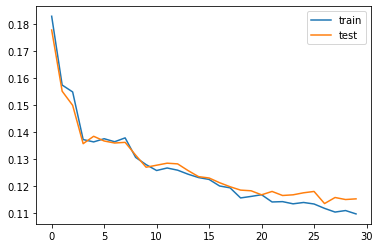

In [ ]:
attrs = ['tokens_count', 'words_count', 'unique_words_count', 'polarity', 'subjectivity', 'uppercase_fraction', 'average_word_length', 'insane_punctuation_count', 'adj_freq', 'adv_freq', 'noun_freq', 'verb_freq', 'other_freq', 'vocabulary_richness']

TP = []
FP = []
TN = []
FN = []


colsample_bytree = 0.3
learning_rate = 0.1
max_depth = 3
alpha = 10
n_estimators = 30


Y = (Y + 1)/2
testY = (testY + 1)/2

eval_s = [(X, Y),(testX,testY)]
xg_reg = xgb.XGBRegressor(objective ='reg:logistic', colsample_bytree = colsample_bytree, learning_rate = learning_rate,
                max_depth = max_depth, eval_metric='error', alpha = alpha, n_estimators = n_estimators)

test_params = {
    'learing_rate':[0.01, 0.05, 0.1]
}
xg_reg.fit(X,Y, eval_set=eval_s, verbose=False)
model = GridSearchCV(estimator = xg_reg,param_grid = test_params, verbose = False)
model.fit(X,Y, eval_set=eval_s, verbose=False)
preds = model.predict(testX)
r = model.best_estimator_.evals_result()

plt.plot(r['validation_0']['error'], label = "train")
plt.plot(r['validation_1']['error'], label = "test")
plt.legend()

preds = np.round(preds)
TP = ((preds == 1) & (testY == 1)).sum()
FP = ((preds == 1) & (testY == 0)).sum()
TN = ((preds == 0) & (testY == 0)).sum()
FN = ((preds == 0) & (testY == 1)).sum()

preds = model.predict(X)
preds = np.round(preds)
train_error_rate = (preds != Y).sum()/len(Y)

error_rate = (FP + FN)/(TP + FP + TN + FN)
print("Error rate: %.3f " % error_rate)
print("Training set error rate: %.3f" % train_error_rate)
print("True positives: %.2f " % TP)
print("False positives: %.2f " % FP)
print("True negatives: %.2f " % TN)
print("False negatives: %.2f " % FN)
